Test compositional lotka volterra algorithm on miaSim time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import pickle as pkl
import torch
from scipy.io import loadmat

# from scipy.special import logsumexp
# from scipy.stats import pearsonr
# from scipy.stats import norm

from compositional_lotka_volterra import *
# from compositional_lotka_volterra import CompositionalLotkaVolterra
# from compositional_lotka_volterra import choose_denom
# from compositional_lotka_volterra import construct_alr
# from compositional_lotka_volterra import estimate_elastic_net_regularizers_cv

from generalized_lotka_volterra import ridge_regression_glv

In [2]:
max_samples = 100
n_samples = 500
n_otu = 4

# path of data file
filename = f"miaSim_GLV_{n_otu}species_oscillating_zero.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/"

In [3]:
# function to import the datafile and put it into the right format
def create_data():
    data = np.genfromtxt(f'{filepath}{filename}', delimiter=",")
    usol = data[1:, :]  # removes header
    if "max_samples" in globals():
        ts = usol[0:max_samples, 0]
        data_y = usol[0:max_samples, 1:]
    else:
        ts = usol[:, 0]
        data_y = usol[:, 1:]
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    print("The coodinates have shape {}".format(ts.shape))
    print("The data has shape {}".format(data_y.shape)) 
    return [ts], [data_y]

In [4]:
T, Y = create_data()

The coodinates have shape (100,)
The data has shape (100, 4)


In [5]:
T[0].shape

(100,)

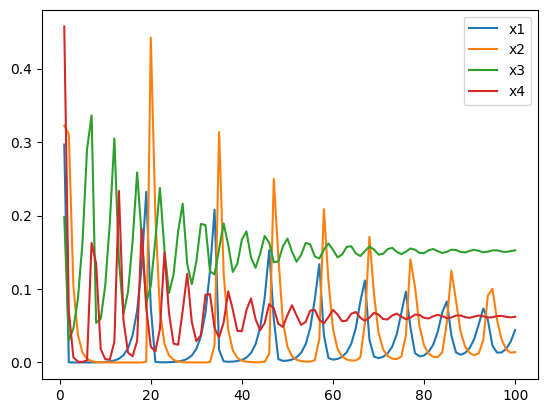

In [6]:
fig, ax = plt.subplots()
for i in np.arange(n_otu):
    ax.plot(T[0], Y[0][:,i], label = f"x{i+1}")
ax.legend()

In [7]:
def adjust_concentrations(Y):
    con =  []
    for y in Y:
        con += y.sum(axis=1).tolist()
    con = np.array(con)
    C = 1 / np.mean(con)

    Y_adjusted = []
    for y in Y:
        Y_adjusted.append(C*y)

    return Y_adjusted

In [8]:
Y = adjust_concentrations(Y)
print(Y)

[array([[1.00020532e+00, 1.08628590e+00, 6.67929883e-01, 1.54195130e+00],
       [8.73679197e-04, 1.04765407e+00, 1.02410338e-01, 2.36013754e-01],
       [1.02024897e-04, 3.51782515e-01, 1.55023410e-01, 2.37905641e-02],
       [7.50514790e-05, 1.25367578e-01, 2.92936740e-01, 4.25996017e-03],
       [1.02957420e-04, 4.56123647e-02, 5.50502022e-01, 2.40369355e-03],
       [1.76453360e-04, 1.67265776e-02, 9.79086968e-01, 1.02455963e-02],
       [3.27893129e-04, 6.15749852e-03, 1.13425781e+00, 5.48497817e-01],
       [6.27634778e-04, 2.27326075e-03, 1.81682549e-01, 4.53460000e-01],
       [1.21453427e-03, 8.42815137e-04, 2.00561652e-01, 6.18283047e-02],
       [2.35975886e-03, 3.14949739e-04, 3.54340081e-01, 1.50305157e-02],
       [4.59050831e-03, 1.19413429e-04, 6.40345804e-01, 1.32624750e-02],
       [8.93075798e-03, 4.65669669e-05, 1.02801268e+00, 9.45295314e-02],
       [1.73598735e-02, 1.91777990e-05, 4.66486869e-01, 7.87315073e-01],
       [3.36879253e-02, 8.78424771e-06, 2.23422356

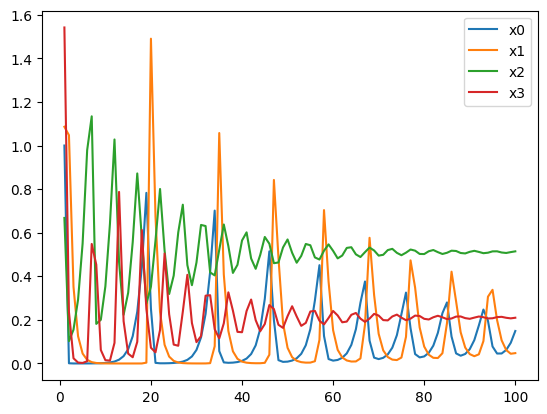

In [28]:
fig, ax = plt.subplots()
for i in np.arange(n_otu):
    ax.plot(T[0], Y[0][:,i], label = f"x{i}")
ax.legend()

In [10]:
P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

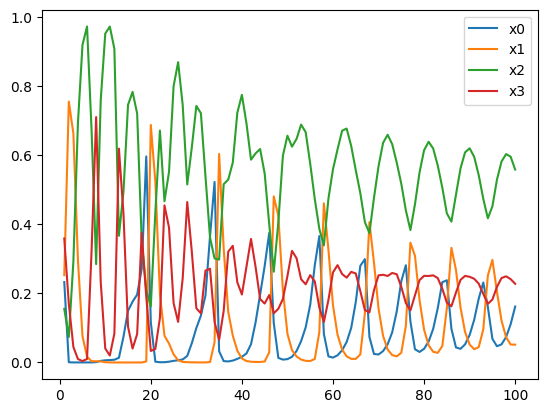

In [27]:
# plot P
fig, ax = plt.subplots()
for i in np.arange(n_otu):
    ax.plot(T[0], P[0][:,i], label = f"x{i}")
ax.legend()

### ALR transformation and denominator search

In [25]:
# denom check (from choose_denom(P))
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)

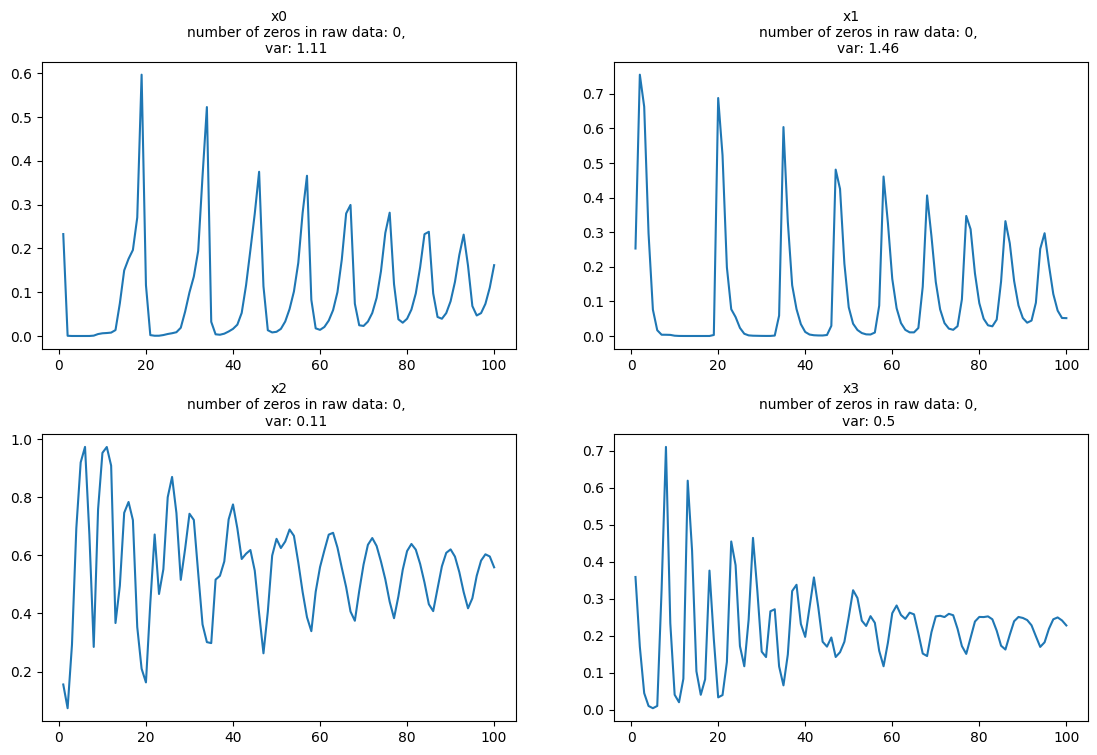

In [32]:
n_row = 2
n_col = 2
fig, axs = plt.subplots(n_row, n_col)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.tight_layout(pad=4.0)
for i in np.arange(n_taxa):
    # plot each taxon timeline separately
    axs[math.floor(i/n_col), (i%n_col)].plot(T[0], P[0][:,i])
    axs[math.floor(i/n_col), (i%n_col)].set_title(f"""x{i}
        number of zeros in raw data: {sum(Y[0][:,i] == 0)},
        var: {round(vars[i],2)}""")
    axs[math.floor(i/n_col), (i%n_col)].title.set_size(10)

In [33]:
denom = choose_denom(P)
print(denom)

ALR = construct_alr(P, denom)

U = [ np.zeros((x.shape[0], 1)) for x in ALR ]

2


In [34]:
alpha, r_A, r_g, r_B = estimate_elastic_net_regularizers_cv(ALR[0], P[0], U = U[0], T=T[0], denom=denom, folds=10, no_effects=True, verbose=False)

	r (0.1, 0.1, 0.1, 0) sqr error 0


In [35]:
clv = CompositionalLotkaVolterra(P, T, denom=denom, pseudo_count=1e-5)

In [20]:
clv.alpha = alpha
clv.r_A = r_A
clv.r_g = r_g
clv.r_B = r_B

In [19]:
# clv.alpha = 1
# clv.r_A = 0.5
# clv.r_g = 0.5
# clv.r_B = 0

In [21]:
clv.train()

In [24]:
denom

2

In [22]:
clv.A

array([[-2.03245625, -3.21907626,  2.05413737,  2.15923108],
       [ 7.41395719, -3.18562107, -2.38903198, -0.7347144 ],
       [ 0.12637214, -0.47117996,  1.99465567, -2.24367072]])

### Generalized Lotka Volterra

In [20]:
def compute_relative_parameters(A_abs, g_abs, B_abs, denom):
    numer = np.array([i for i in range(A_abs.shape[0]) if i != denom])
    A_rel = A_abs[numer,:] - A_abs[denom,:]
    B_rel = B_abs[numer,:] - B_abs[denom,:]
    g_rel = g_abs[numer] - g_abs[denom]

    return A_rel, g_rel, B_rel

In [25]:
A_glv, g_glv, B_glv = ridge_regression_glv(log_Y, U, T, clv.r_A, clv.r_g, clv.r_B)

A_rel, g_rel, B_rel = compute_relative_parameters(A_glv, g_glv, B_glv, clv.denom) # to compare with clv

In [27]:
A_glv, g_glv, B_glv

(array([[-2.43548892, -3.09591246,  0.0886769 , -0.60889688],
        [ 5.75671246, -1.49911893, -0.35965732, -1.12714302],
        [-0.00228994,  0.04856792, -1.08397977, -1.31552638],
        [ 0.03652997, -0.03560841,  3.37537798, -2.22355698]]),
 array([ 0.82750543, -0.04498232,  0.82725047, -1.24909739]),
 array([[0.],
        [0.],
        [0.],
        [0.]]))